In [1]:
import os
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import jax
import jax.numpy as jnp

import livelossplot
import tqdm

from mlutil import misc
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')

In [2]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
data_obj = fetch_olivetti_faces()

X_original = data_obj['data']

#binarize data
X = 1.0 * (X_original > X_original.mean())

y = data_obj['target']

indices = np.arange(len(y))

indices_train, indices_test, y_train, y_test = train_test_split(indices, y, stratify=y, test_size=0.1, random_state=0)

X_train = X[indices_train]
X_test = X[indices_test]

## Example images

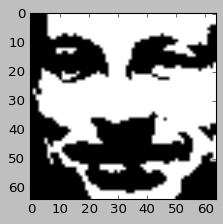

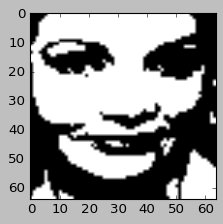

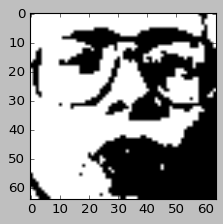

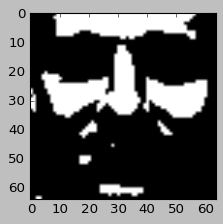

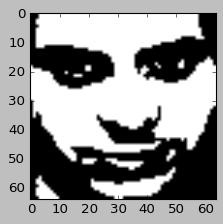

In [4]:
for i in range(5):
    plt.figure(figsize=(3,3))
    misc.display_img_vector(X_train[i])

In [5]:
dim = X_train.shape[1]
n_hidden = 225

init_std = np.sqrt(n_hidden)
init_weights = np.random.uniform(
    size=(dim, n_hidden),
    low=-2 / init_std,
    high= 2 / init_std
)
W = jnp.array(init_weights)

### RBM definitions

RBMs are undirected graphical models with the following structure ($h_i, v_j$ are binary):

<p align="center"><img src="http://40.media.tumblr.com/5e4a23b85f61e2aaeeb1188c2e35536a/tumblr_inline_npz2ev1m5Y1rnd3q0_540.png" /></p>

The joint probability is given by:
$$E(v, h) = vWh$$

$$P(v, h) = \frac{e^{-E(v, h)}}{Z}$$

($Z$ is a normalizing factor, $Z = \sum_{u, g}e^{-E(u, g)}$)

That means that $$P(h|v) = \prod_{i}P(h_i|v)$$ and consequently from the definition it follows that $$P(h_i = 1 \mid v) = \frac{1}{1 + exp((vW)_{i})}$$

RBMs are optimized using approximation to likelihood.

$$P(x) = \frac{\sum_{h}P(x, h)}{Z}$$

The algorithm that is used to approximate derivatives of log likelihood is called **contrastive divergence**, see for example [this link](http://deeplearning.net/tutorial/rbm.html).

In [6]:
def get_probabilities_from_other(W, other):
    energy = other @ W
    return jax.nn.sigmoid(energy)


def sample_bernoulli(probas, key):
    uniform_samples = jax.random.uniform(shape=probas.shape, key=key)
    bernouli_samples = (probas > uniform_samples)
    return bernouli_samples.astype('float')


def sample_from_other(W, other, key):
    proba = get_probabilities_from_other(W, other)
    return sample_bernoulli(proba, key)


def free_energy(W, visible):
    energy = visible @ W
    return - jax.nn.softplus(energy).sum(axis=1)


def cd1_variables(W, visible):
    hidden0 = get_probabilities_from_other(W, visible)
    visible1 = jax.lax.stop_gradient(get_probabilities_from_other(W.T, hidden0))
    return hidden0, visible1


def cd1(W, visible):
    hidden0, visible1 = cd1_variables(W, visible)
    goodness0 = free_energy(W, visible)

    # we do this not to mess up gradient computation
    visible1_correct = visible1
    goodness1 = free_energy(W, visible1)

    return (goodness0 - goodness1).mean()

In [7]:
def l2_penalty(W, weight_decay):
    return weight_decay * (W ** 2).sum(axis=1).mean()


def loss(W, visible, weight_decay):
    return cd1(W, visible) + weight_decay * (W ** 2).sum(axis=1).sum()

In [8]:
probas = get_probabilities_from_other(W, jnp.array(X_train[:100]))

In [9]:
V = jnp.array(X_train[:100])

## Data utils

In [10]:
def get_sampler(X, batch_size):
    n_examples = X.shape[0]
    indices = np.arange(n_examples)
    np.random.shuffle(indices)
    for i in range(0, n_examples, batch_size):
        yield X[i:i+batch_size]
        
def augment_with_binary_noise(V, noise_pct = 0.01):
    return V * (np.random.uniform(size=V.shape) > noise_pct)

In [11]:
X_t, X_val = train_test_split(X_train, test_size=0.1)

In [12]:
def train_rbm(
        W,
        X_train,
        X_val,
        n_epochs=200,
        batch_size=8,
        lr=0.001,
        beta=0.5,
        wd=0.002,
        log_callback_epoch=5):
    loss_plot = livelossplot.PlotLosses(outputs=[livelossplot.outputs.MatplotlibPlot()])
    penalty_fn = jax.jit(l2_penalty)
    loss_fn = jax.jit(loss)
    loss_grad = jax.grad(loss_fn)

    M = jnp.zeros_like(W)
    V_val = jnp.array(X_val)


    for i in tqdm.tqdm(range(n_epochs)):
        data_sampler = get_sampler(X_t, batch_size)

        training_loss = 0
        for V in data_sampler:
            V = V * np.random.randint(0,2, V.shape)
            M = beta * M + loss_grad(W, jnp.array(V), wd)
            W -= lr * M
            training_loss += loss_fn(W, V, wd) 

        training_loss = training_loss / np.ceil(len(X_t) // batch_size)
        val_loss = loss_fn(W, V_val, wd) 
        penalty_value = penalty_fn(W, wd) 

        loss_plot.update({"loss": training_loss, "val_loss": val_loss, "l2_penalty": penalty_value})
        if i % log_callback_epoch == 0:
            loss_plot.send()    

    return W, loss_plot


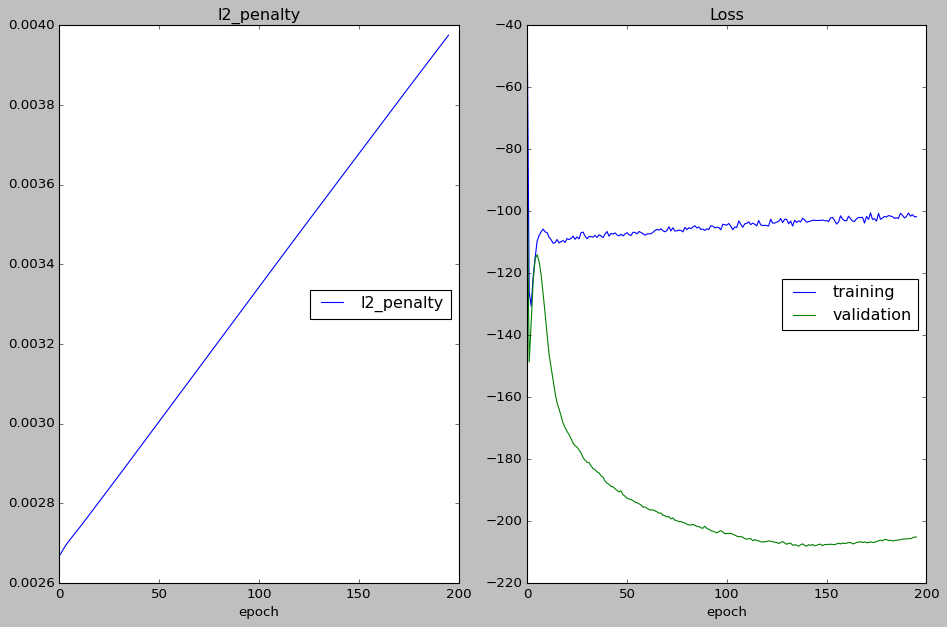

100%|██████████| 200/200 [00:26<00:00,  7.54it/s]


In [13]:
W, loss_plotter = train_rbm(W, X_t, X_val)

In [14]:
X_pred = get_probabilities_from_other(W.T, get_probabilities_from_other(W, X_val[:10]))
X_reconstructed = X_pred > 0.5

In [15]:
def show_reconstruction(original, reconstructed, reconstructed_probabilities, howmany=5):
  original_faces = original.reshape(-1, 64, 64)
  reconstructed_faces = reconstructed.reshape(-1, 64, 64)
  reconstructed_probabilities_faces = reconstructed_probabilities.reshape(-1, 64, 64)
  
  for i in range(howmany):
    test_face = original_faces[i]
    reconstructed_face = reconstructed_faces[i]
    reconstructed_proba_face = reconstructed_probabilities_faces[i]
    
    plt.subplot(331)
    plt.imshow(reconstructed_proba_face, cmap='gray')
    plt.title('probabilities')
    plt.axis('off')
    
    plt.subplot(332)
    plt.imshow(test_face, cmap='gray')
    plt.title('original')
    plt.axis('off')
    
    plt.subplot(333)
    plt.imshow(reconstructed_face, cmap='gray')
    plt.title('reconstructed binarized')
    plt.axis('off')
    
    plt.show()

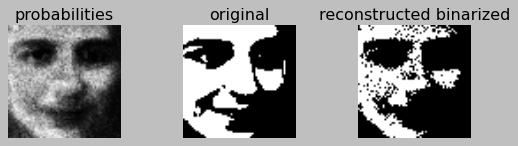

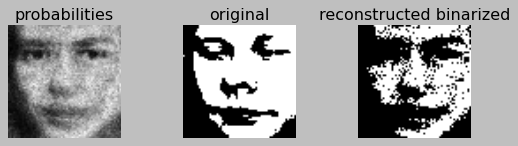

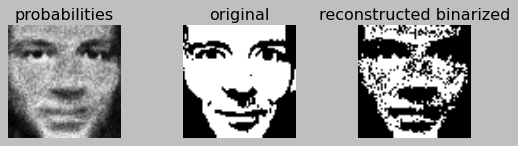

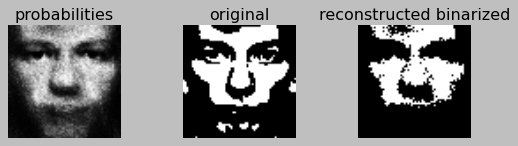

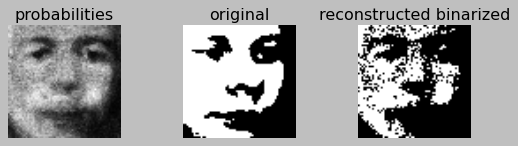

In [16]:
show_reconstruction(X_val, X_reconstructed, X_pred)